# Visualization experiments: Graphs
* This notebook contains code that visualizes the graphs and parts of it.

#### Load requirements

In [1]:
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import networkx
from networkx.algorithms.cluster import clustering
from networkx.algorithms import shortest_paths, pagerank
from networkx.drawing.nx_pylab import draw
from networkx import convert
from nltk import word_tokenize
import pandas as pd
from termcolor import colored

#### Helper functions

In [2]:
def load_data(file_name):
    '''
    function that loads CSV files
    without adding new column for index
    '''
    df = pd.read_csv(file_name, index_col=[0])
    return df

In [3]:
def label_list(graph):
    '''
    function to create a list of all labels for drawing the graph
    '''
    labels = {}    
    for node in graph.nodes(): 
            labels[node] = node[28:]          
            
    return labels

In [4]:
def return_orig_nodes(df, graph, ind):
    '''
    function that returns the nodes of the graph present in the text
    arguments:
    df:           name of df
    graph:        networkx graph
    ind:          index of text in the df, needed for recalling the original words from the text 
    '''
    return [dic["URI"] for dic in literal_eval(df.iloc[ind]['annotations']) if dic["URI"] in graph.nodes()]

In [5]:
def return_edge_dic(df, ind):
    '''
    function to create a dictionary of edges and their labels for drawing graph
    in the form {edge_tuple : edge_label}
    '''
  
    edges = {tup[0:2]:tup[2] for tup in literal_eval(df.iloc[ind]["sel_graph_data"])}
    
    for key in edges.keys():
        edges[key] = edges[key]['prop'].split('/')[-1]
        
    return edges

In [6]:
def print_text(df, ind):
    '''
    function that prints out a text
    and highlights the words found by the annotation tool
    used for illustration purposes
    '''
    file_name=df.iloc[ind]['path']
    with open(file_name) as f:
        file=f.read()
    for word in word_tokenize(file):       
        
        if (
            word.lower() in map(lambda x:x.lower(), [item for sublist in [dic["surfaceForm"] for dic in literal_eval(df.iloc[ind]['annotations'])] for item in word_tokenize(sublist)])
            or word[:-1].lower() in map(lambda x:x.lower(), [item for sublist in [dic["surfaceForm"] for dic in literal_eval(df.iloc[ind]['annotations'])] for item in word_tokenize(sublist)])
            or word[:-2].lower() in map(lambda x:x.lower(), [item for sublist in [dic["surfaceForm"] for dic in literal_eval(df.iloc[ind]['annotations'])] for item in word_tokenize(sublist)])
        ):
            
            print(colored(word,'red'), end = ' ')
            
        else:
            print(word, end = ' ')

In [7]:
def get_nodes_from_text(df, ind, text):
    '''
    a function that checks a text segment and returns the nodes that belong to it
    arguments:
    df:     name of df
    ind:    index of text inside dataframe, needed for returning the nodes
    text:   text segment to check, in string form
    '''
    sel_nodes = set()
    nodes = literal_eval(df.iloc[ind]['annotations'])
    
    for node in nodes:
        
        if node['surfaceForm'].lower() in text.lower():
            
            sel_nodes.add(node["URI"])
        
    return (sel_nodes)

In [8]:
def draw_graph(df, ind, feature=None, parts=False, nodes=None, font_size = 10): 
    '''
    function that draws graph
    by defult draws whole graph, 
    if parts=True and set of nodes is given, will only draw part of the graph including those nodes
    if a feature is given, nodes will be sized according to the feature value
    feature can be: node_degree, pagerank, clustering
    saves file into png/index_of_text.png and shows it as well
    
    '''

    graph = convert.from_edgelist(literal_eval(df.iloc[ind]["sel_graph"]))

    small_graph=networkx.Graph()
    
    if parts:   
        for edge in graph.edges():
            #print(edge)
            if edge[0] in nodes and edge[1] in nodes:
                small_graph.add_edge(edge[0],edge[1])
                
        for node in nodes:
            if node in graph:
                small_graph.add_node(node)

        annotation_pairs = list(itertools.combinations(nodes, 2))
        for pair in (set(annotation_pairs)): 
            if (pair[0] in small_graph.nodes() and pair[1] in nodes 
                and pair[0] in graph and pair[1] in graph):
                paths = list(networkx.simple_paths.all_simple_paths(graph, (pair[0]), (pair[1]), 4))
                if paths != []:
                    for path in paths:
                        for related_nodes in list(zip(path, path[1:])):
                            small_graph.add_edge(
                                related_nodes[0],
                                related_nodes[1])               
                
    else:
        small_graph=graph
        nodes = return_orig_nodes(df, graph, ind)    
    
    pos=networkx.layout.fruchterman_reingold_layout(small_graph)
    
    labels = label_list(small_graph)
    
    plt.figure(figsize=(30,20)) 
    
    if feature=='node_degree':
        node_size = [200*small_graph.degree[node] for node in small_graph]
    elif feature =='pagerank':
        node_size = [100000*value for value in list(pagerank(small_graph).values())]
    elif feature == 'clustering':
        node_size = [10000*value for value in list(clustering(small_graph).values())]
        
    else:
        node_size=1000

    node_color = ['purple' if node in nodes else 'pink' for node in small_graph]
    
        
    networkx.draw(small_graph, pos, with_labels = False,edge_color='black',width=1,linewidths=1,
    node_size=node_size, node_color=node_color,alpha=0.9)

    networkx.draw_networkx_labels(small_graph, pos, labels, font_size=font_size,font_color='black')        
    
    networkx.draw_networkx_edge_labels(small_graph, pos, 
                {key:val for (key,val) in return_edge_dic(df, ind).items() if key in small_graph.edges()}
                 , font_size=10,font_color='b', label_pos=0.3)

    plt.savefig('png/'+str(ind)+'.png')
    plt.show()


#### Load DF

In [9]:
df = load_data("csv/britannica_with_features.csv")

#### Demo: Whole graphs

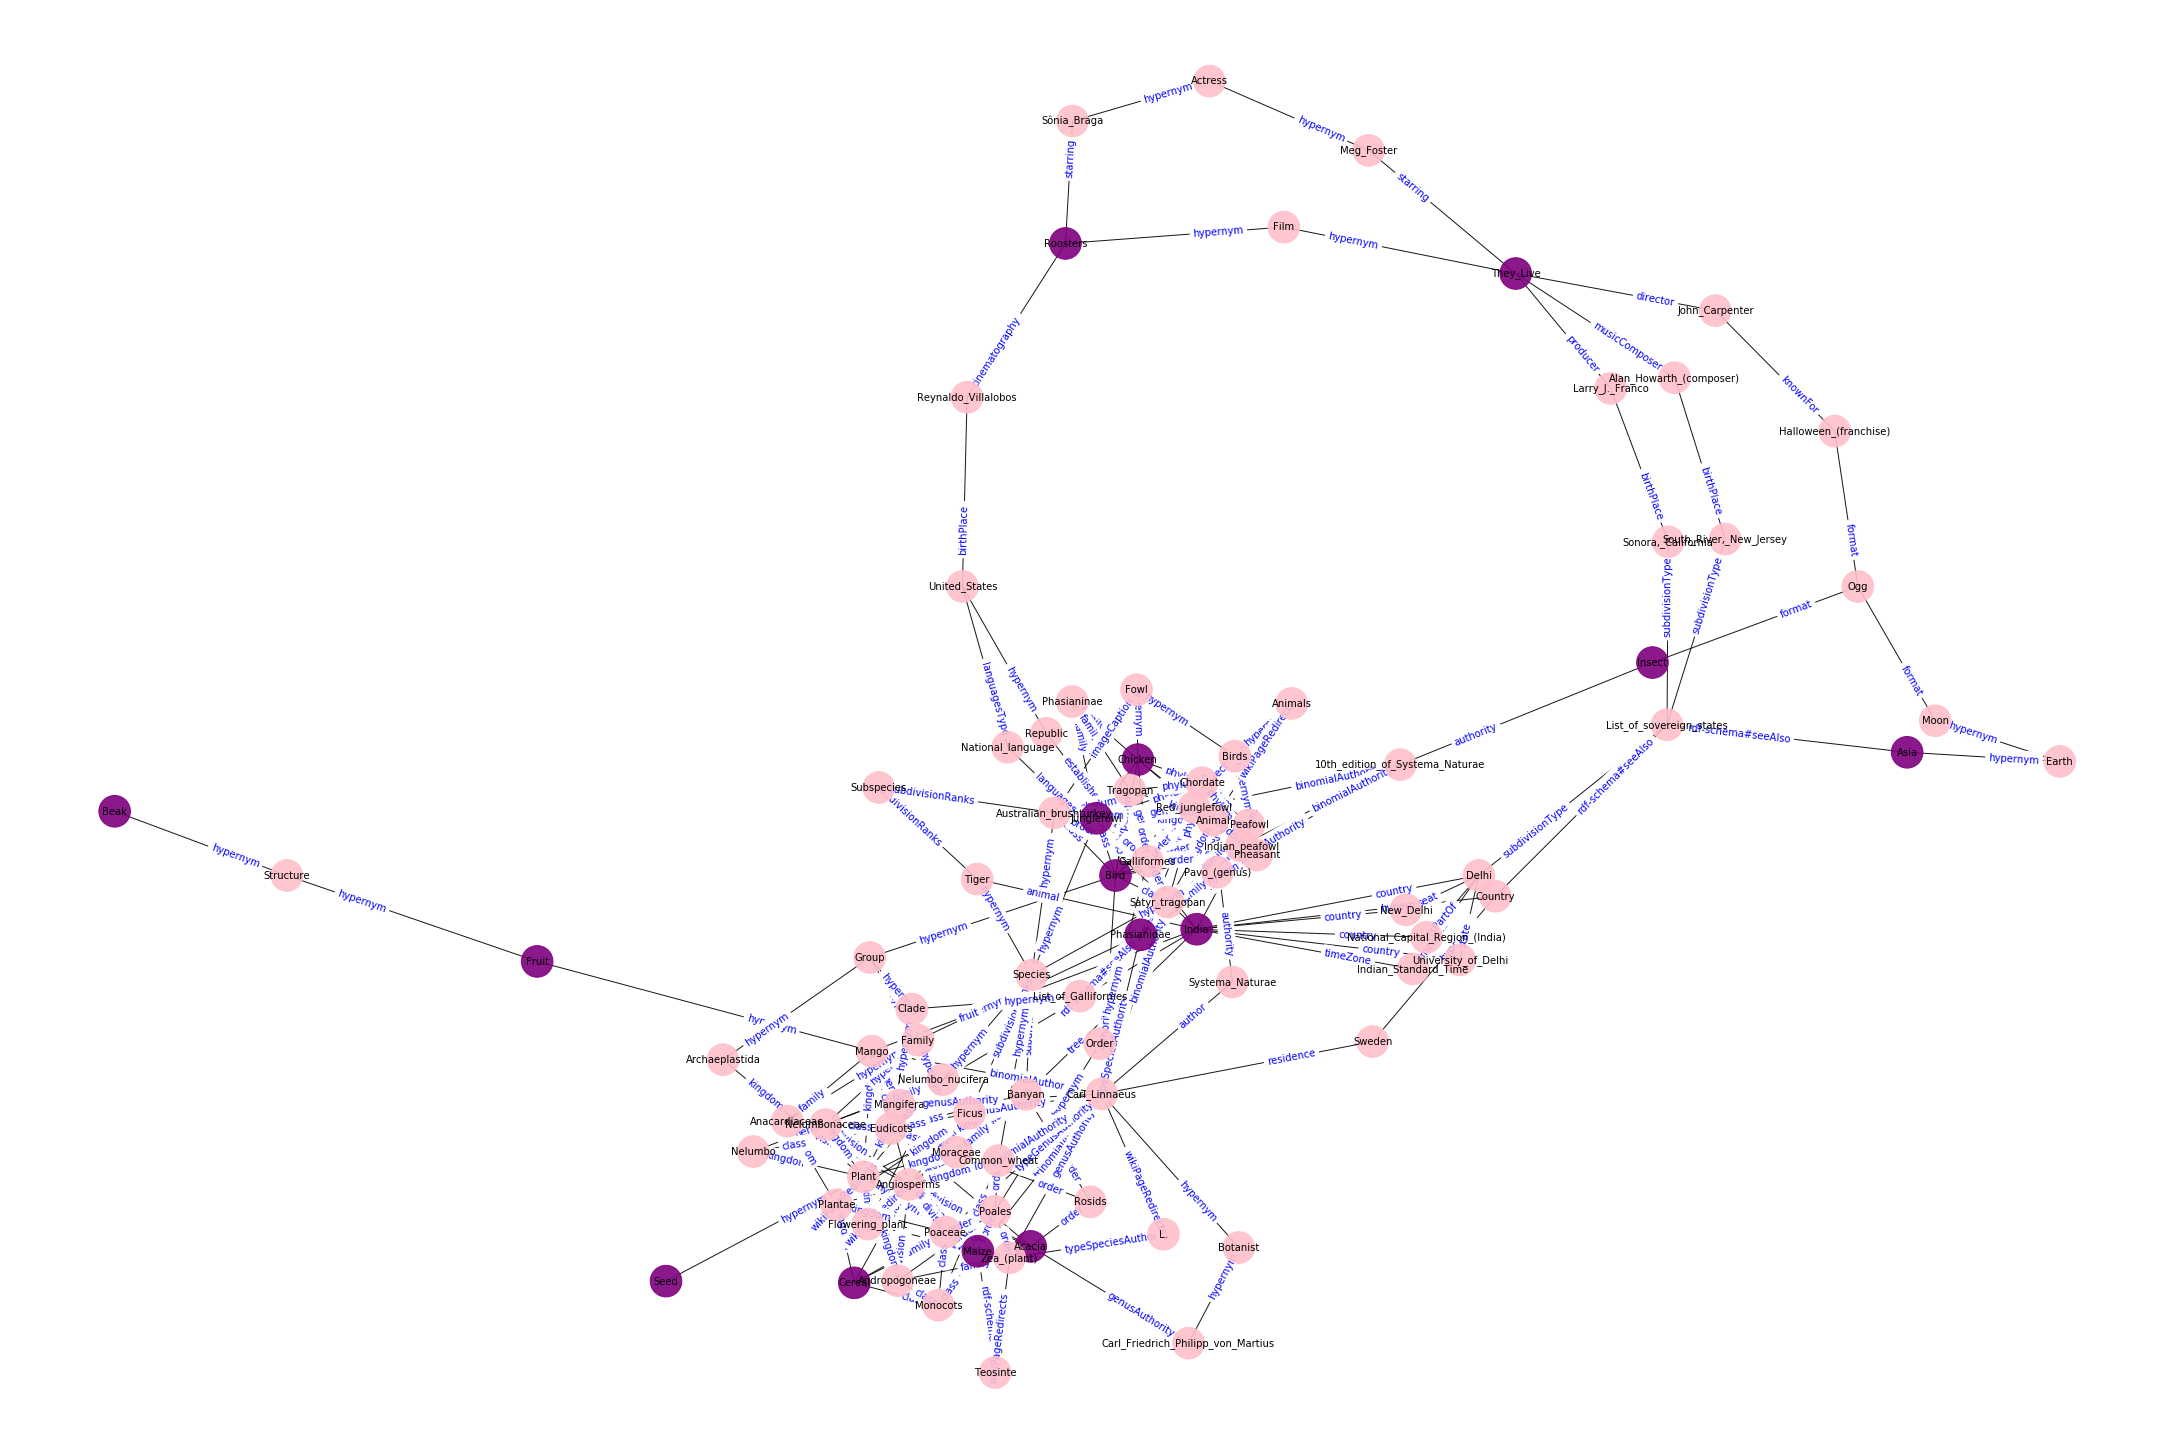

In [10]:
# kids
draw_graph(df, 6)

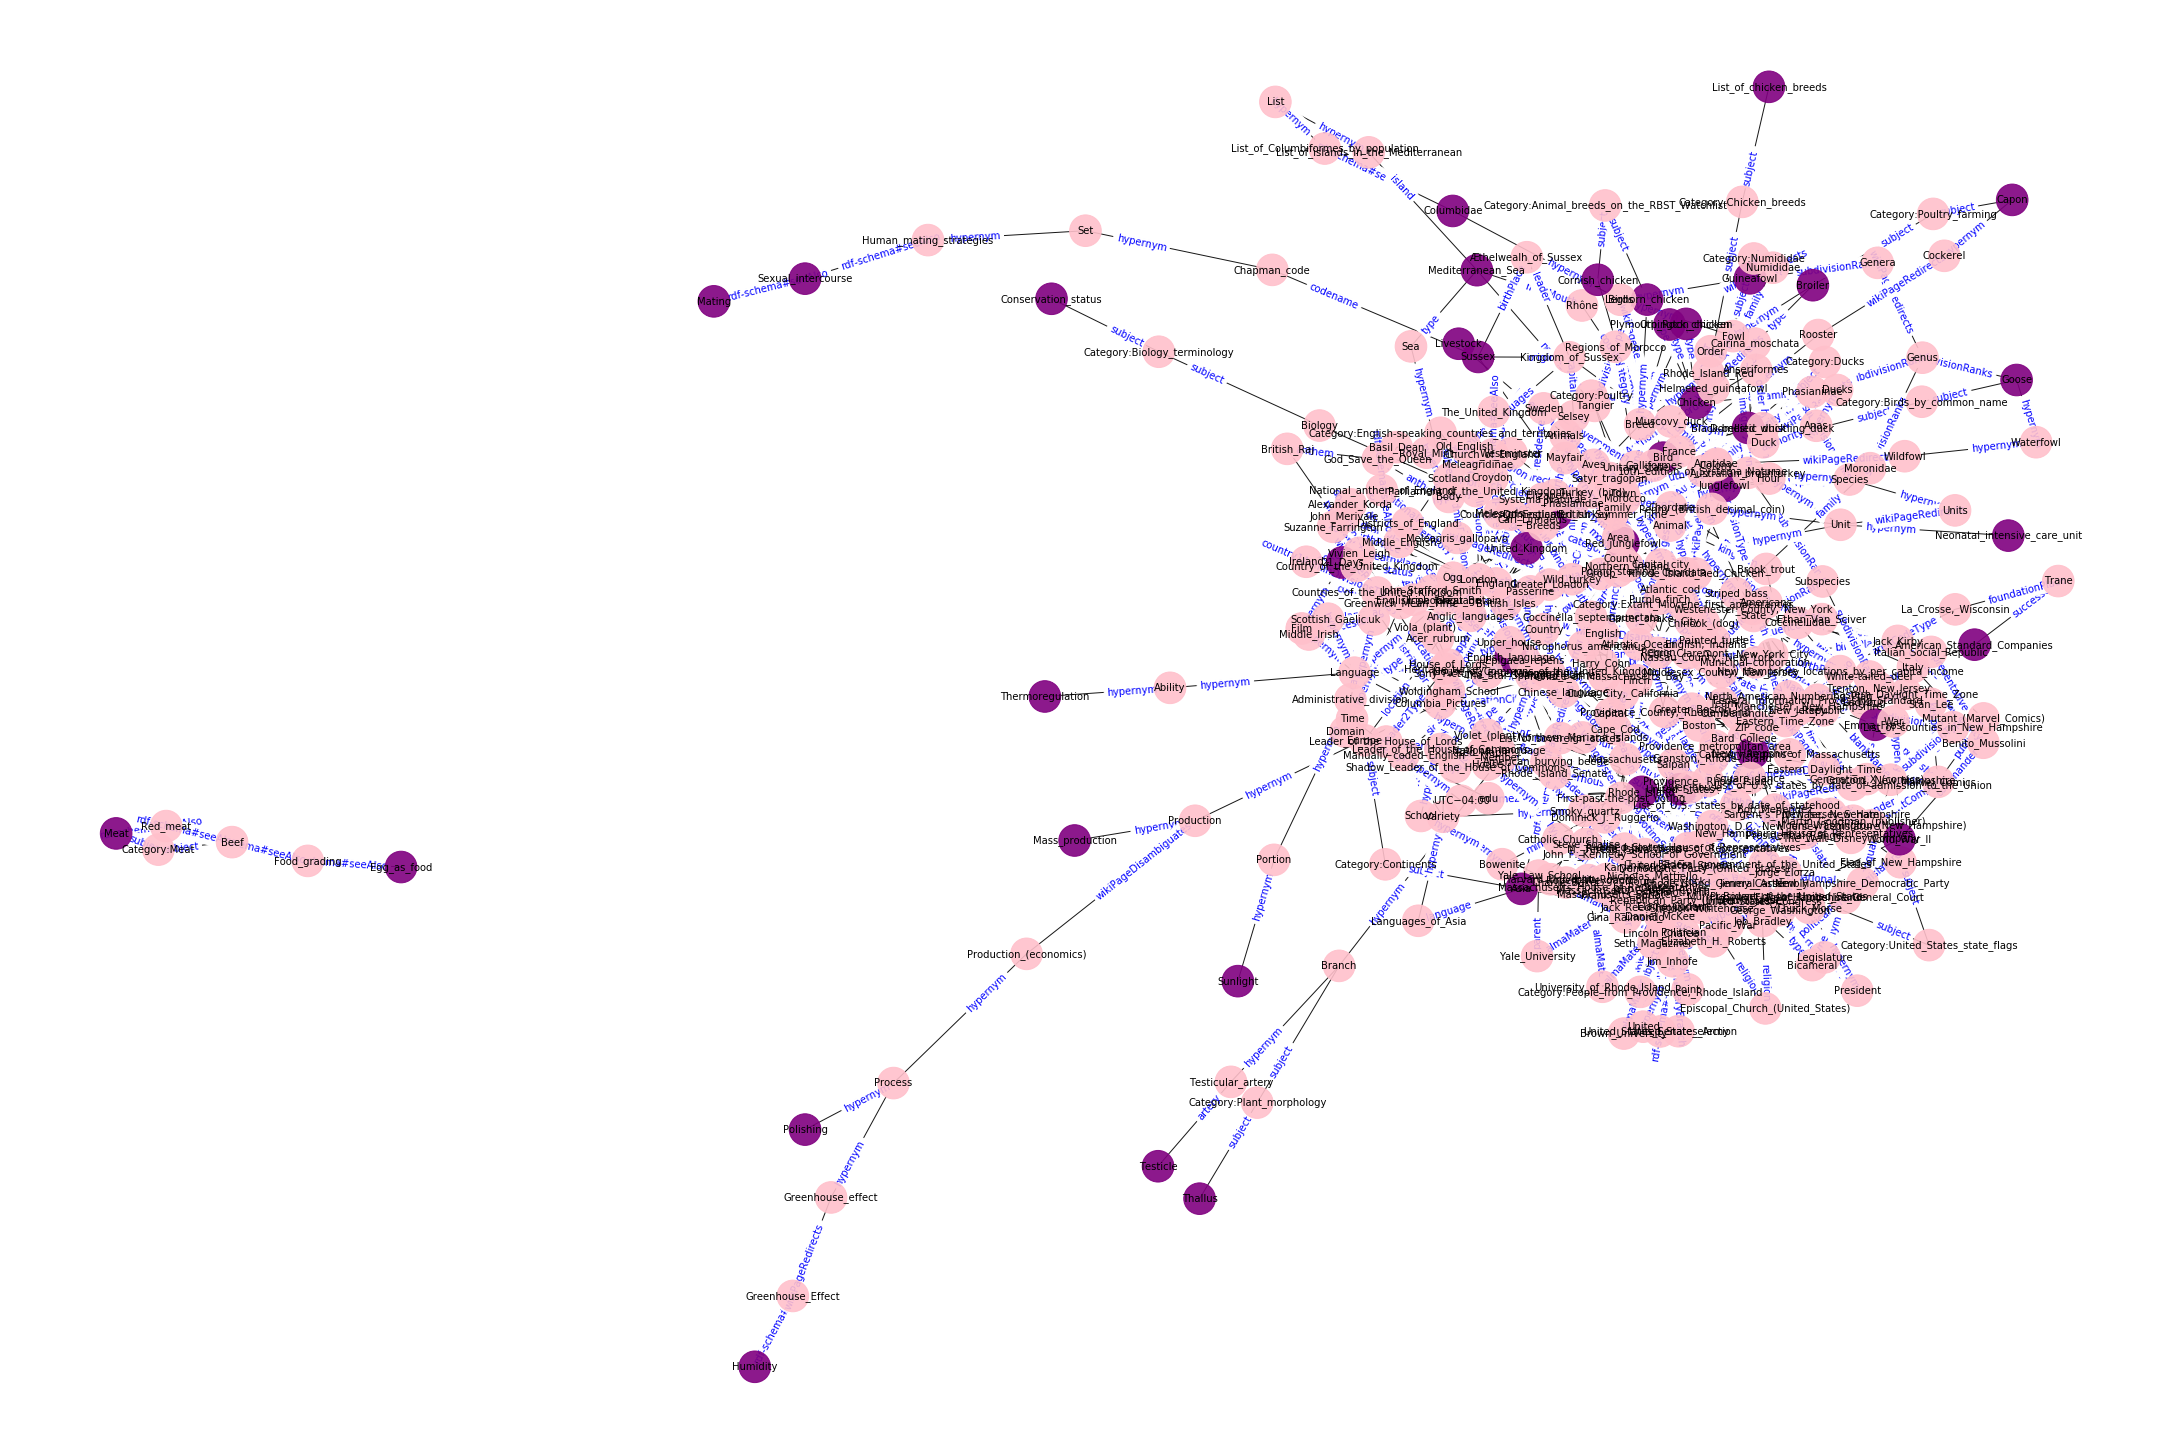

In [11]:
# student
draw_graph(df, 8)

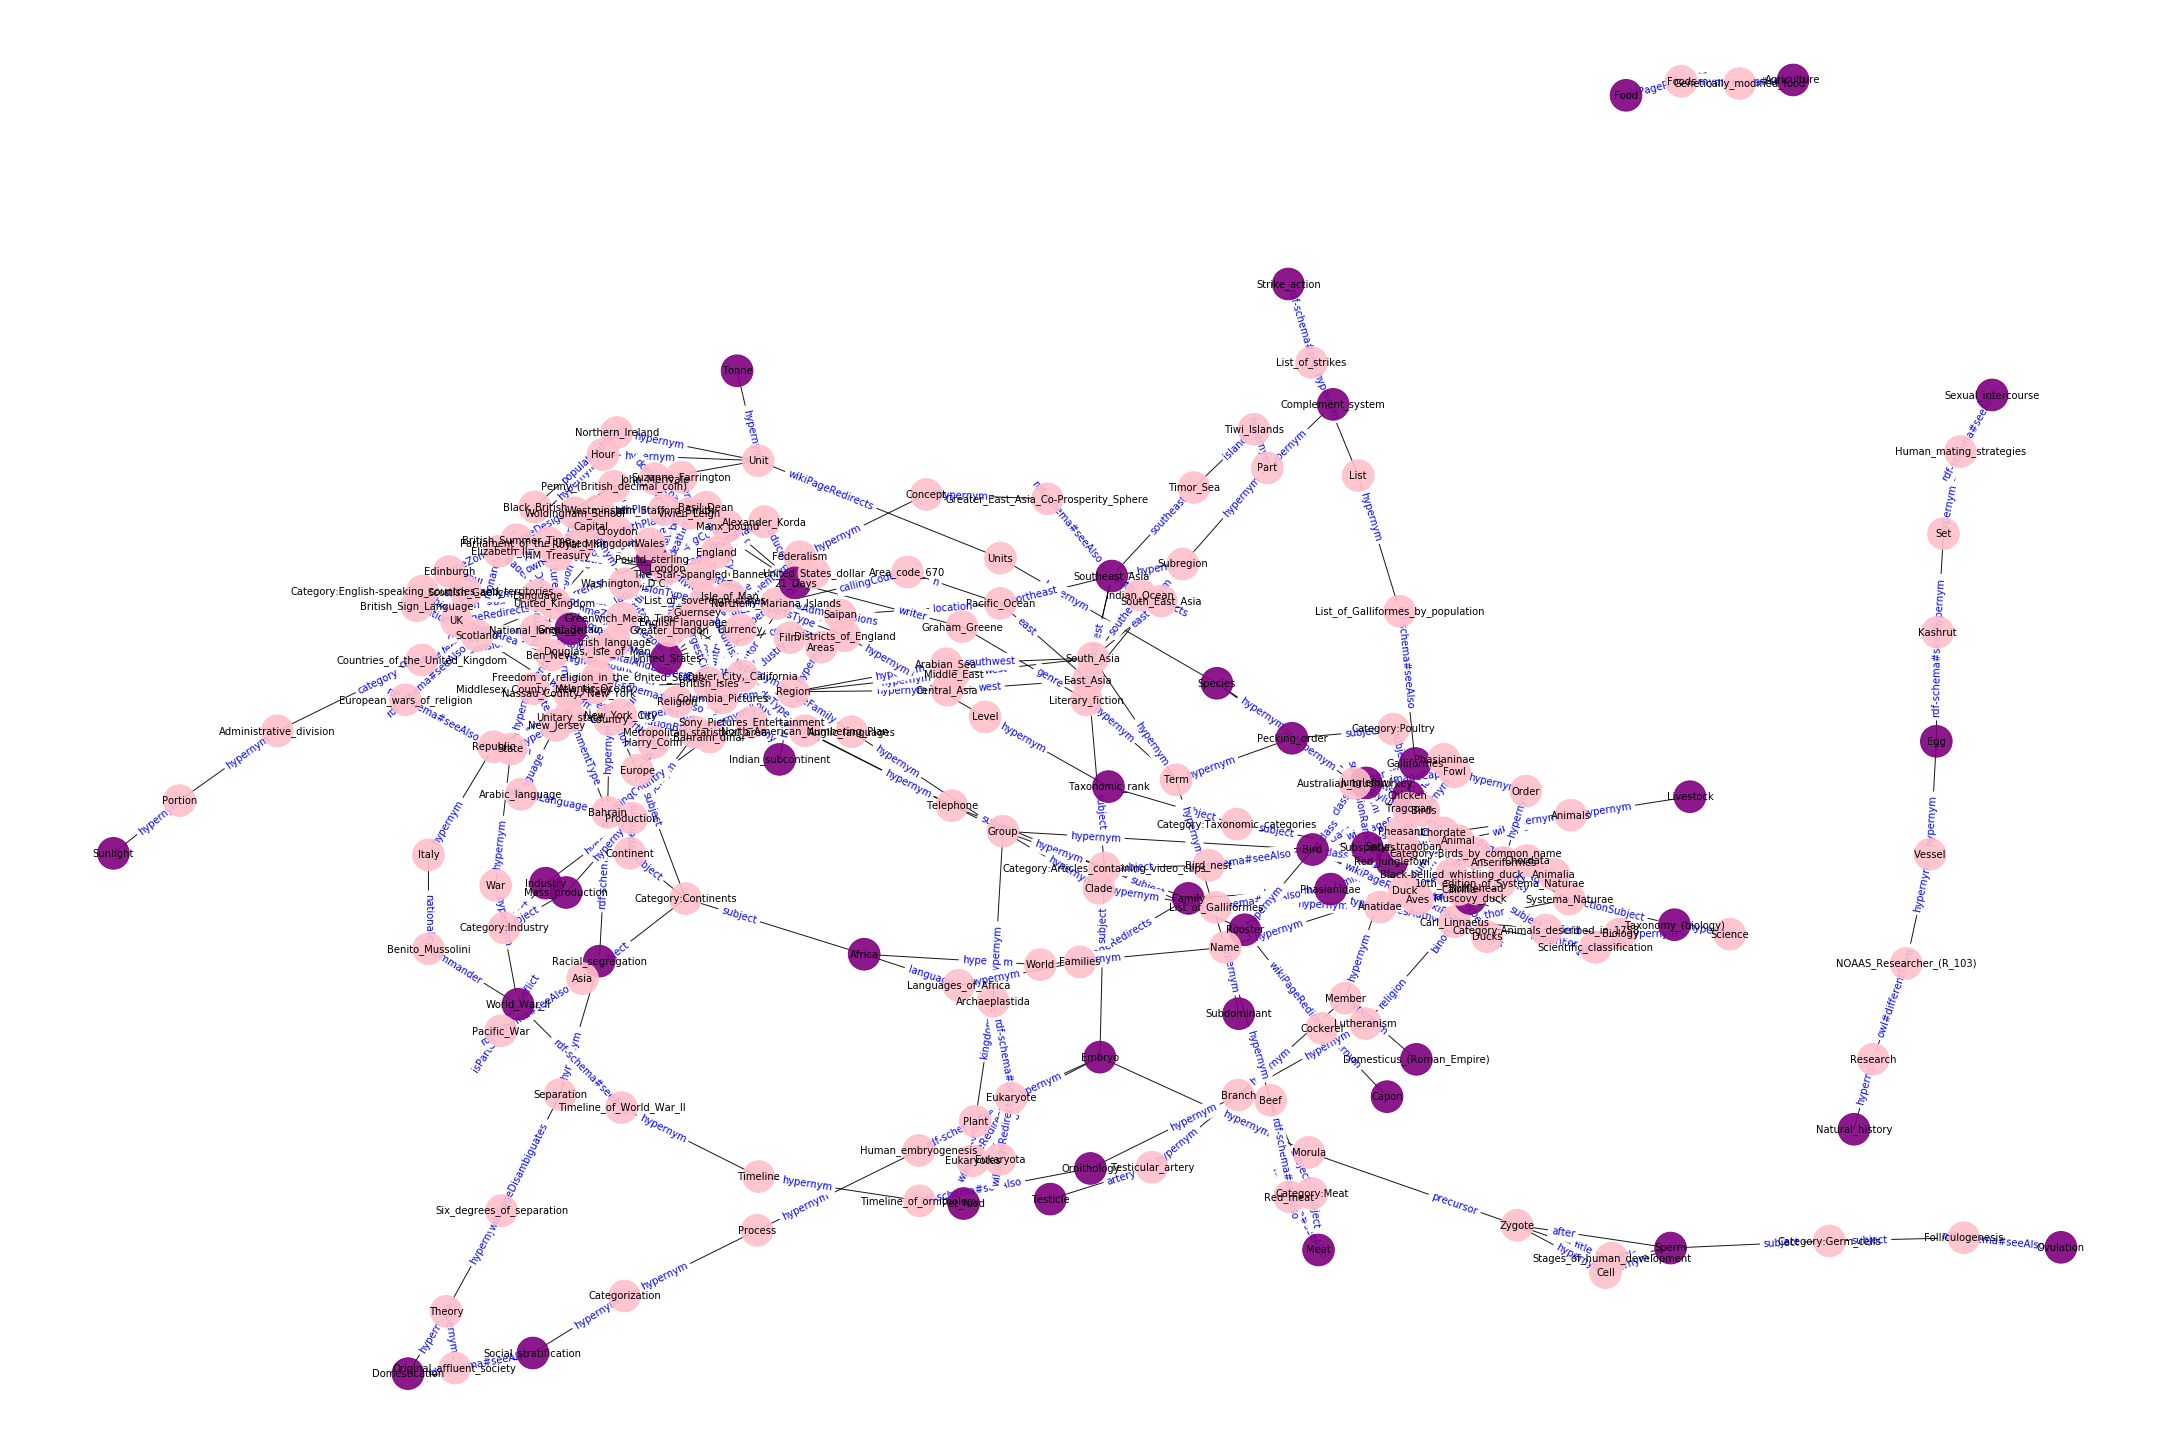

In [12]:
# scholar
draw_graph(df, 7)

In [13]:
#kid
print_text(df, 6)

The chicken is a bird that people all over the world raise for its meat , eggs , and feathers . It belongs to the group of domesticated , or tame , birds called poultry . Chickens have short wings and a heavy body . This makes it hard for them to fly very far . Male chickens are called roosters . Roosters often have brightly colored feathers . They can be red , green , brown , black , or other colors . Female chickens are called hens . Hens are usually brown or white . Both males and females have one or two wattles . A wattle is skin that hangs from the throat . Male and female chickens also have a comb , which is skin that sticks up from the top of the head . Farmers usually keep chickens inside large , modern buildings . They feed the birds corn and other grains . Some farmers allow their chickens to roam free outdoors . These chickens usually roost , or sleep , inside at night . Hens can lay more than 200 eggs a year . If a hen mates with a rooster before laying eggs , the eggs will

In [14]:
#student
print_text(df, 8)

One of the most widely domesticated fowls is the chicken . It is raised worldwide for its meat and eggs . The chicken belongs to the group of domesticated birds called poultry , which also includes turkeys , ducks , geese , guinea fowl , and pigeons . The scientific name of the domestic chicken is Gallus gallus . Its ancestor is the wild red jungle fowl . The chicken is a heavy-bodied bird adapted to life on the ground . The short wings are not suited for long-distance flight , and the legs and toes are adapted for running and scratching . It has a short , stout , curved beak . The female , called a hen , is usually drab . Both the male ( rooster ) and the female have one or two wattles—naked , fleshy growths hanging from the chin or throat—and a large comb , or crest , of similar tissue . Hens are raised for meat and for their edible eggs ; farmers have developed numerous breeds and varieties to fulfill commercial requirements . Most immature males are castrated ( in modern times usua

In [15]:
#scholar
print_text(df, 7)

chicken , ( Gallus gallus ) , any of more than 60 breeds of medium-sized poultry that are primarily descended from the wild red jungle fowl ( Gallus gallus , family Phasianidae , order Galliformes ) of India . The chicken is perhaps the most widely domesticated fowl , raised worldwide for its meat and eggs . Despite the chicken ’ s close relationship with the red jungle fowl , there is evidence that the gray jungle fowl ( G. sonneratii ) of southern India and other jungle fowl species , also members of Gallus , may have contributed to the bird ’ s ancestry . There is some debate about what the chicken ’ s scientific name should be . Although many taxonomists and ornithologists consider it as a domesticated form of the wild red jungle fowl , some classify it as a subspecies of the red jungle fowl ( i.e. , G. gallus domesticus ) , whereas others , including the U.S. Department of Agriculture , classify the bird as G. domesticus . Natural history Chickens have a squat and rounded appearan

#### Demo: Sample sentences 

In [16]:
kid = ' The canary is a small bird known for its singing .'
student = 'One of the most popular pet songbirds all over the world is the canary .'
scholar = 'canary , ( species Serinus canaria ) , popular cage bird of the family Fringillidae ( order Passeriformes ) . '

In [17]:
nodes_kid = get_nodes_from_text(df,3,kid)
nodes_student = get_nodes_from_text(df,5,student)
nodes_scholar = get_nodes_from_text(df,4,scholar)

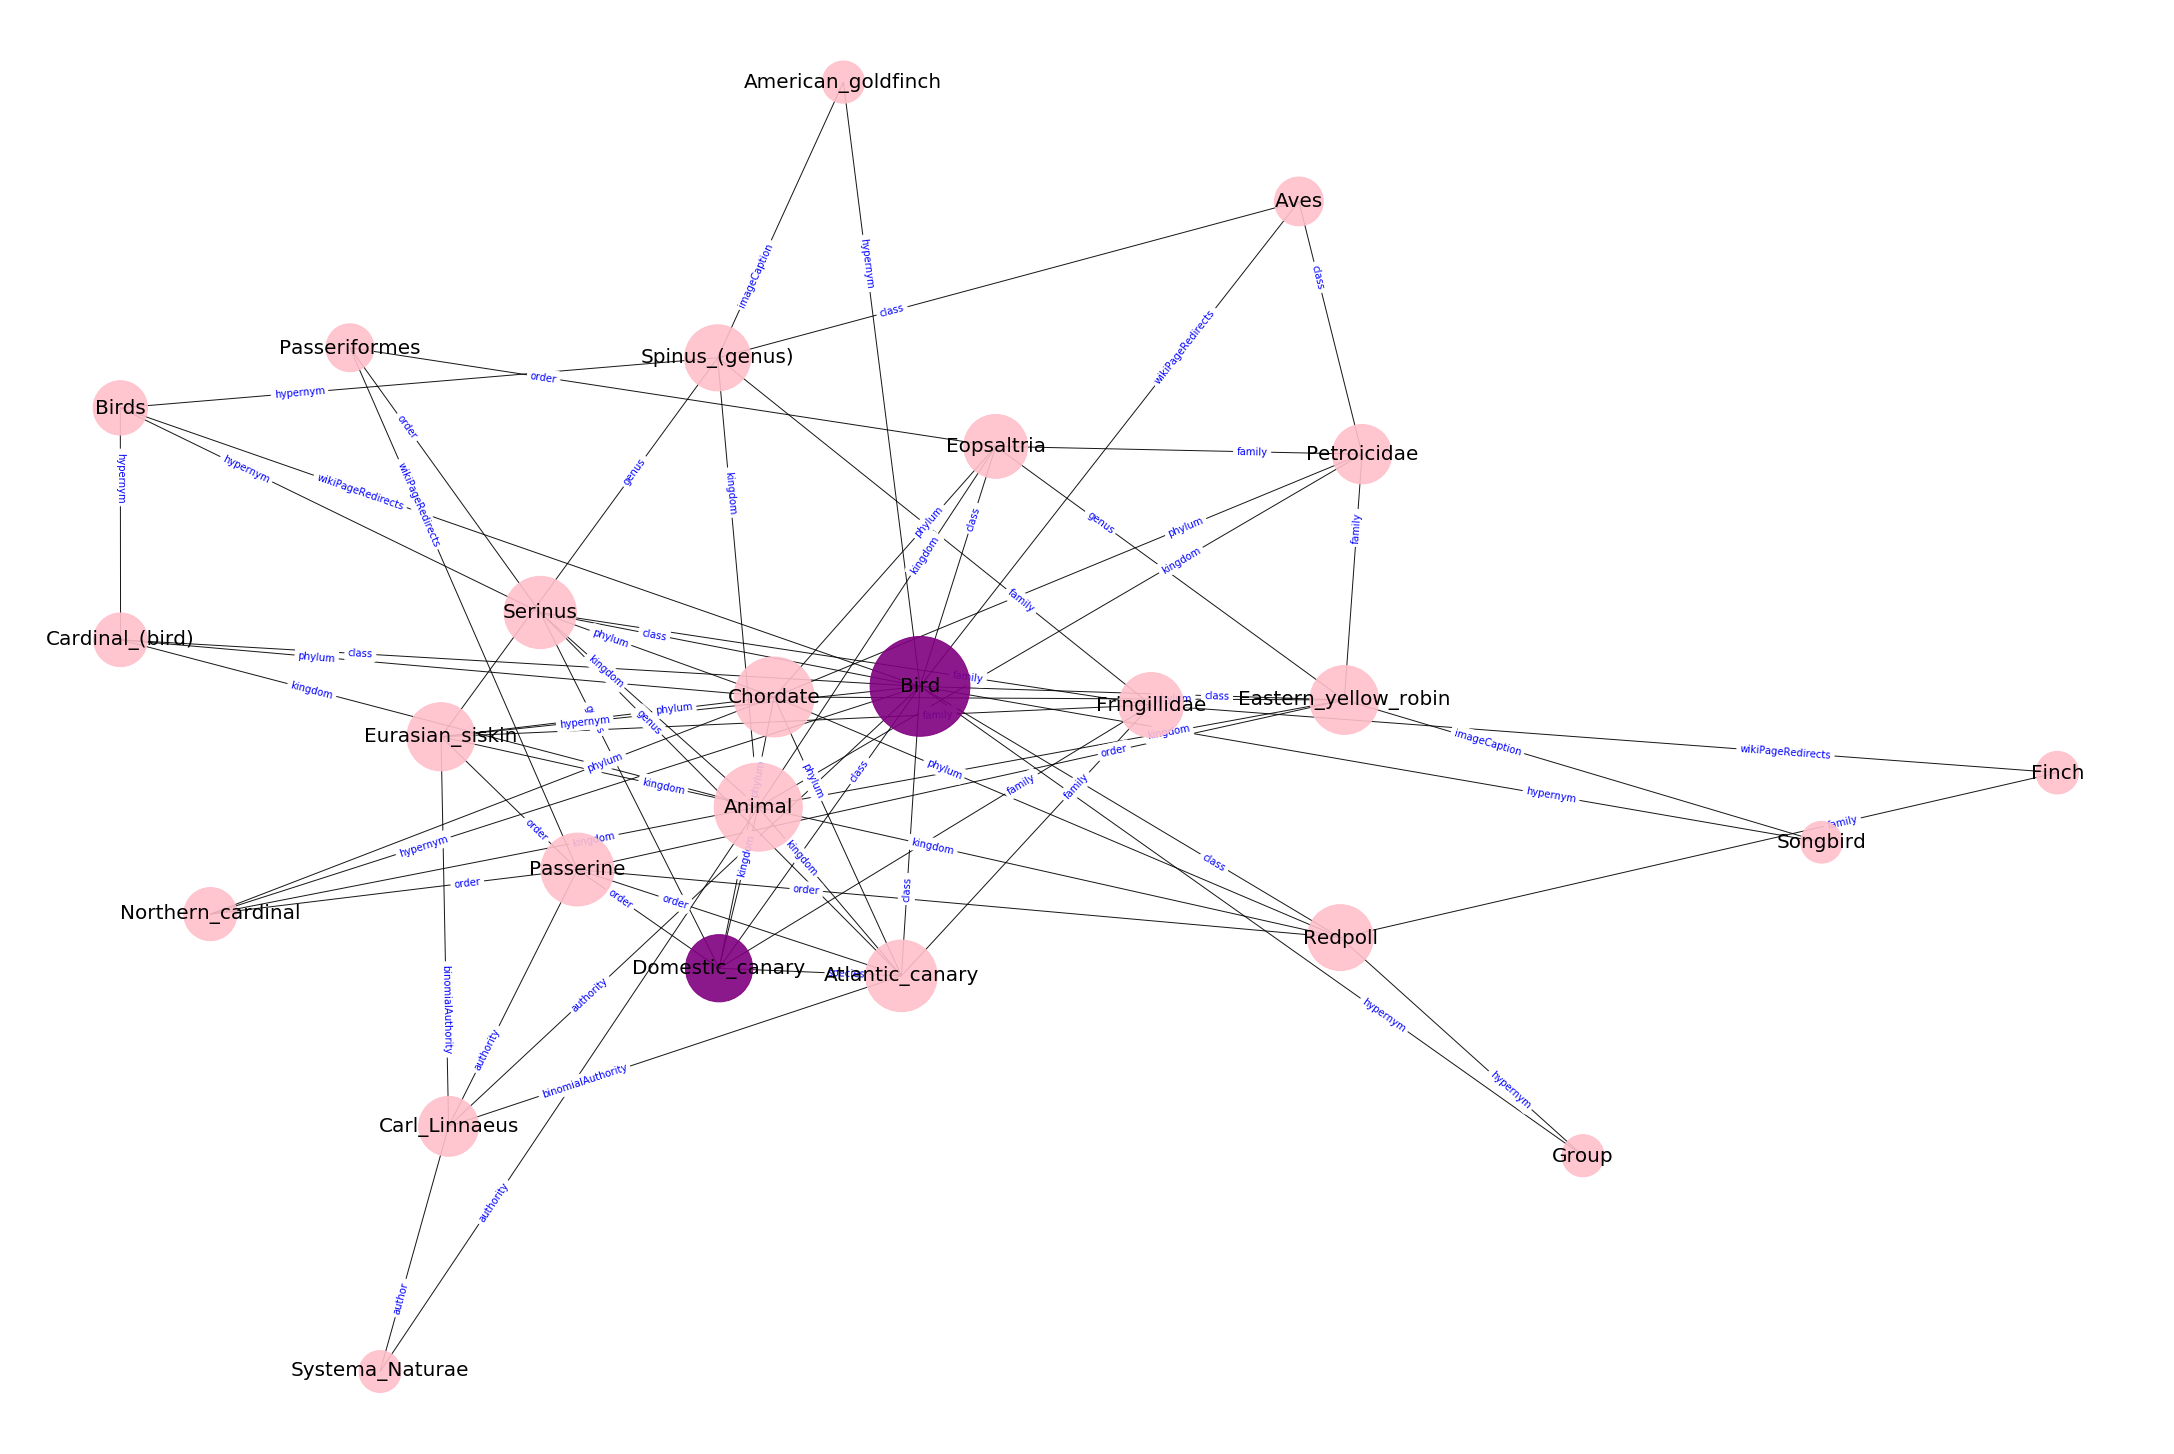

In [18]:
draw_graph(df, 3, 'pagerank', parts=True, nodes=nodes_kid, font_size=20)

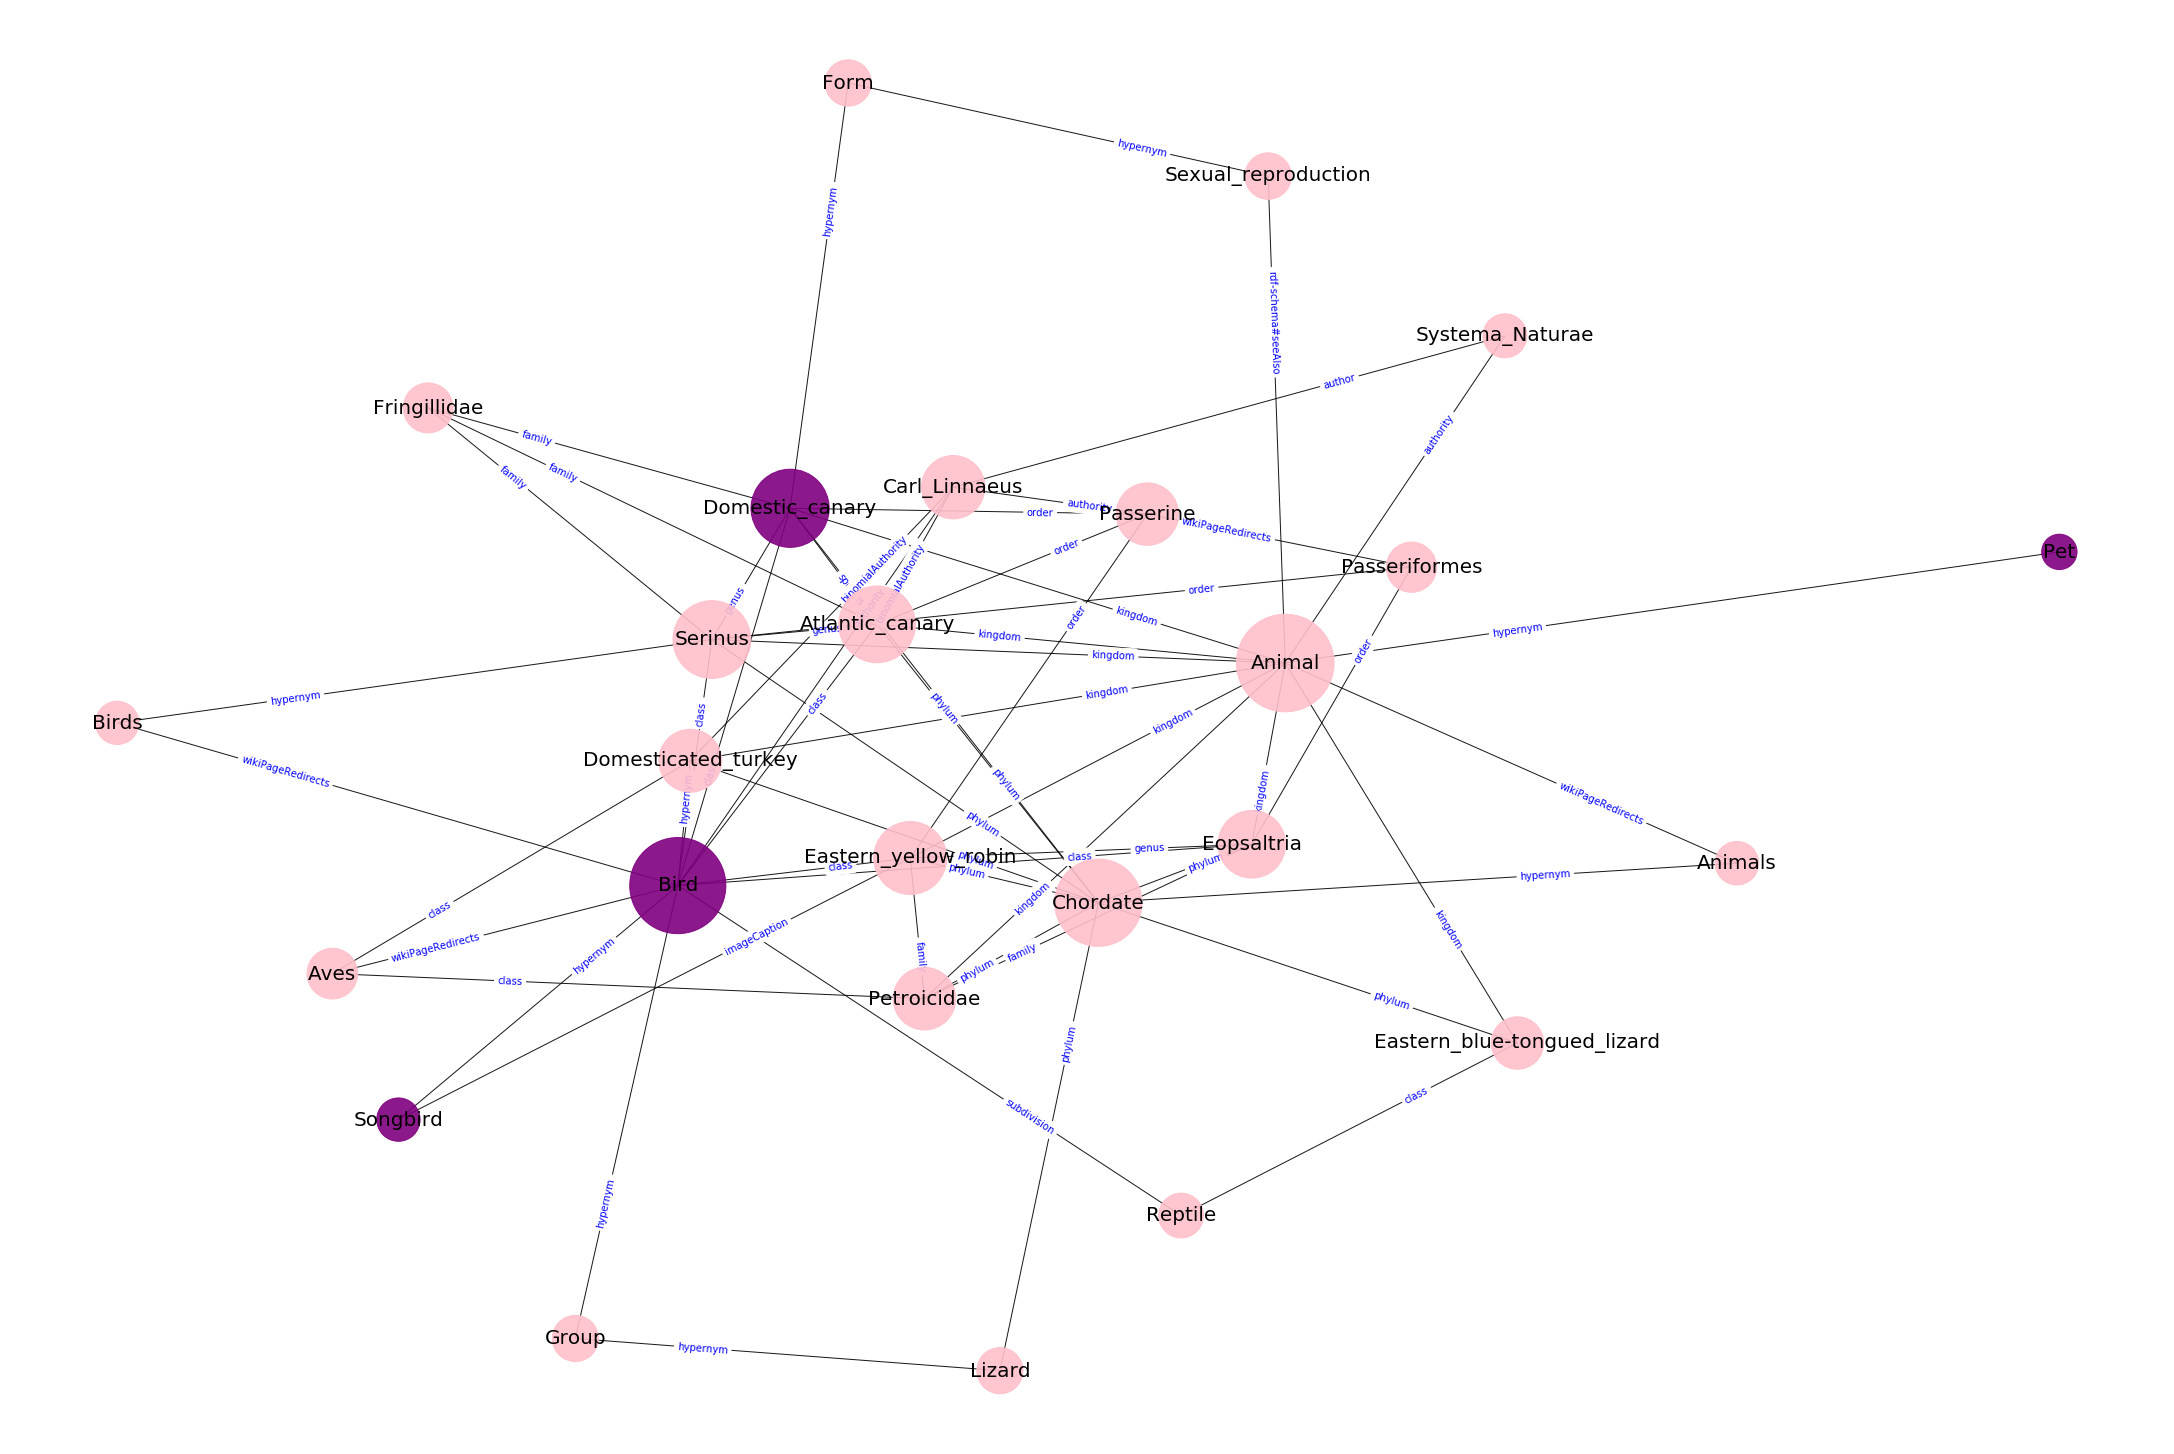

In [19]:
draw_graph(df, 5, 'pagerank', parts=True, nodes=nodes_student, font_size=20)

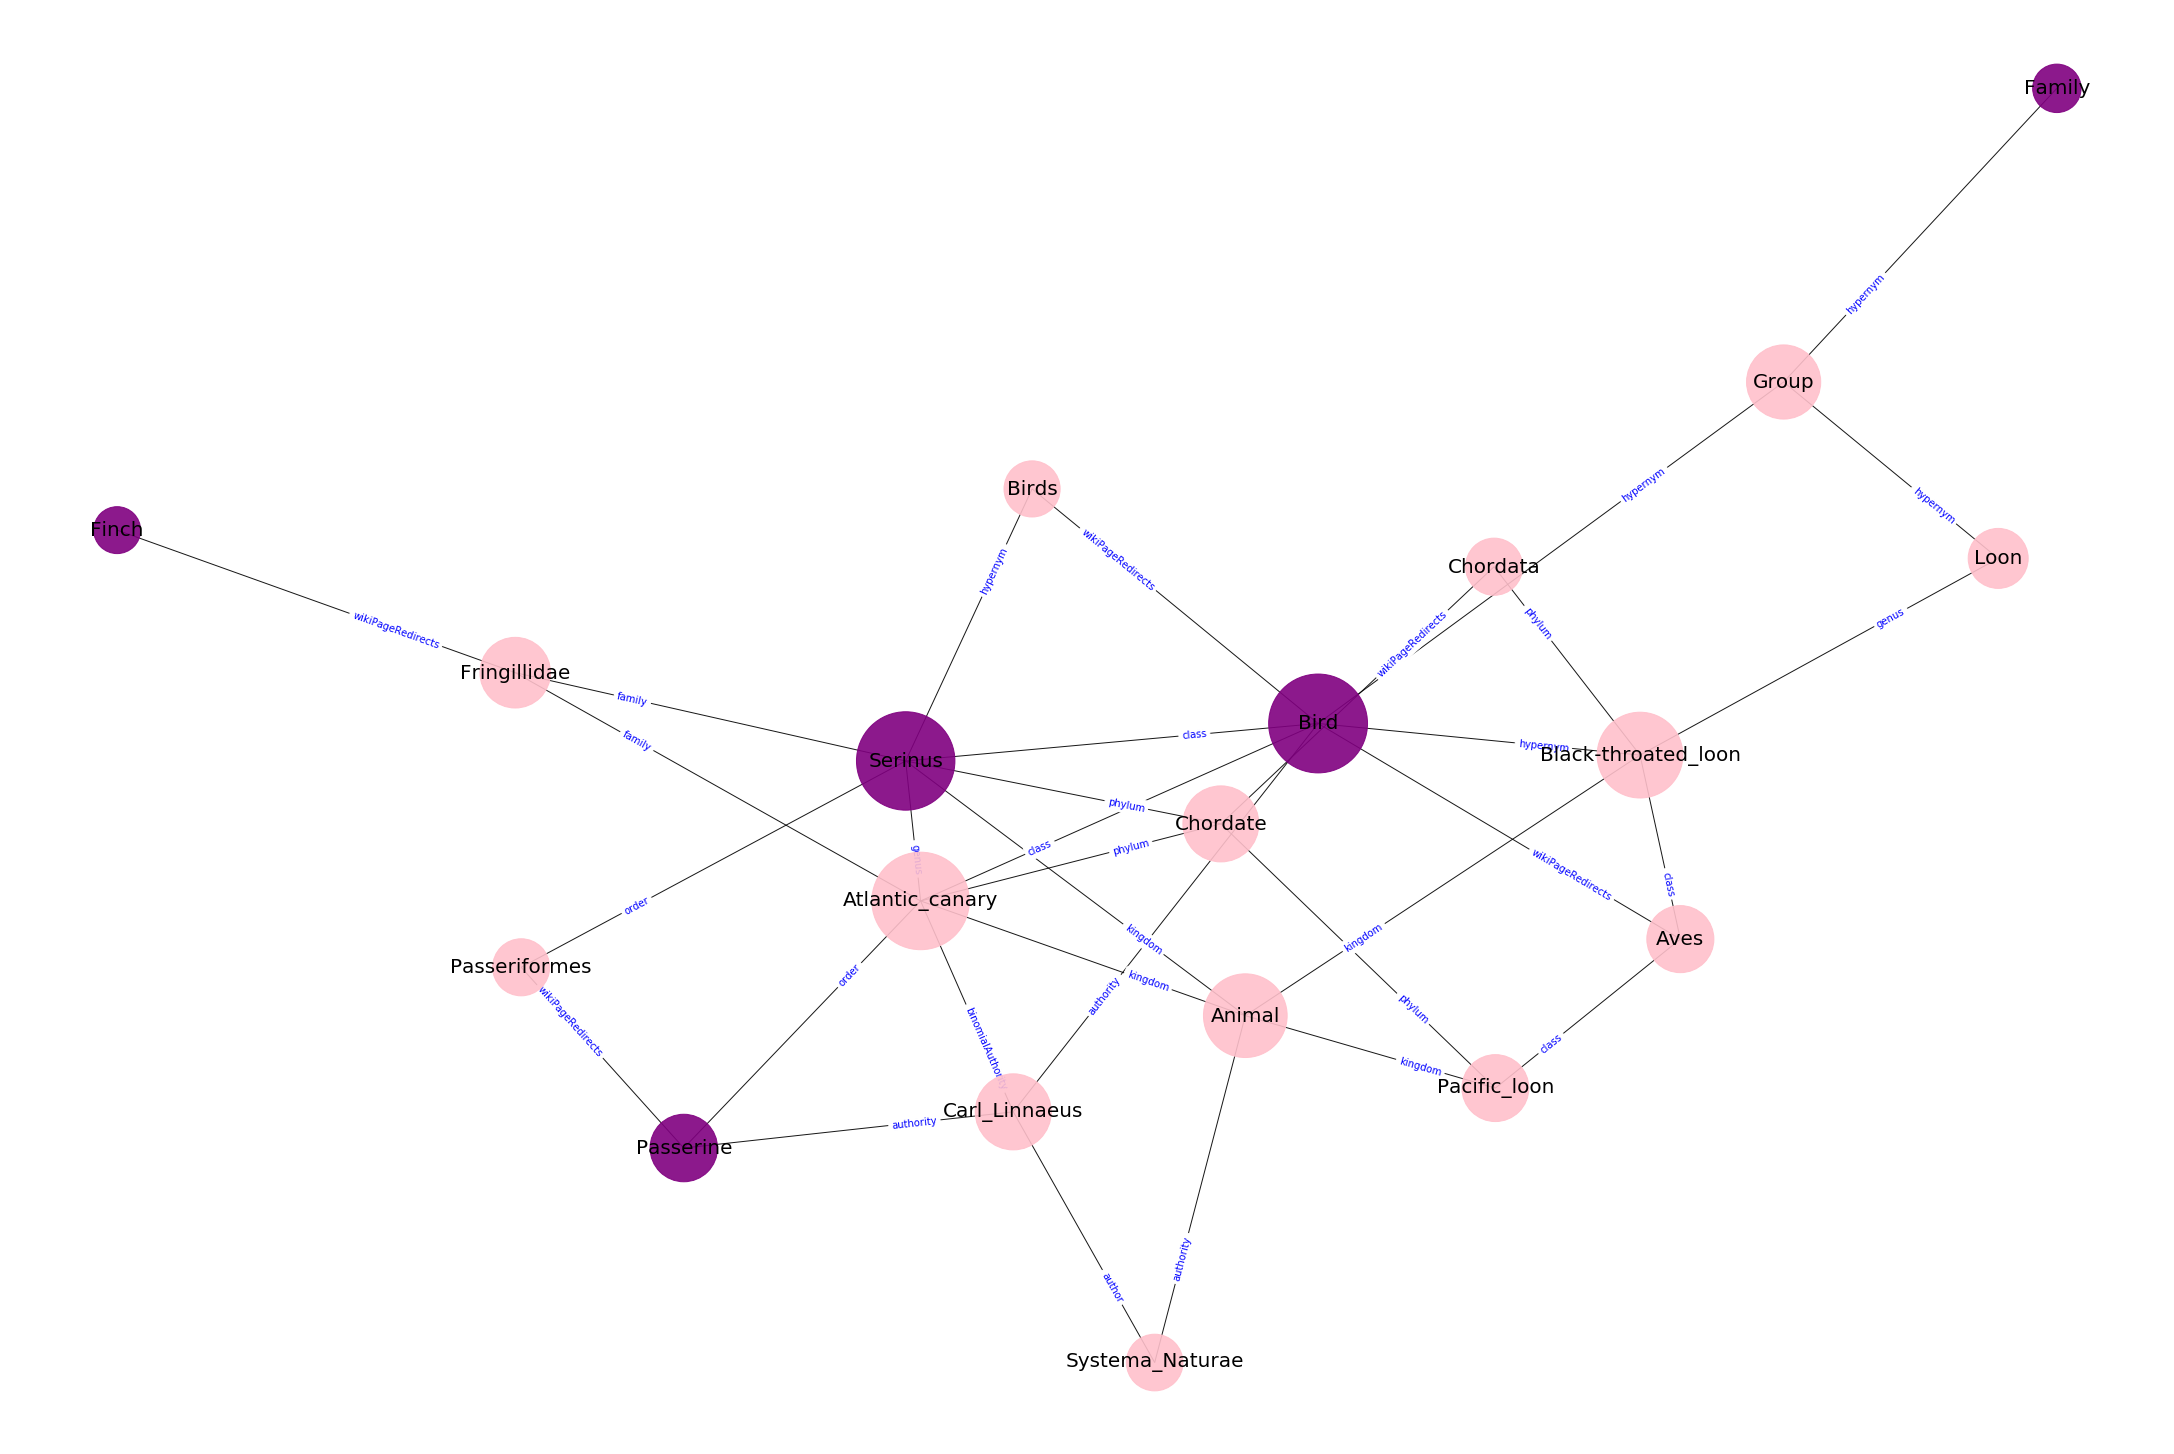

In [20]:
draw_graph(df, 4, 'pagerank', parts=True, nodes=nodes_scholar, font_size=20)